# PUBLIC LB 3.25811

In [1]:
import pandas as pd

In [2]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [4]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv( 'test.csv', encoding='utf-8')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0, encoding='utf-8')

In [5]:
import re 
def preprocessing_data(df):
    
    # 데이터 정리
    df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Book-Title']]
    df['Main_Title'] = [i.split('  ')[0] for i in df['Book-Title']]
    df['Sub_Title'] = [''.join(i.split('  ')[1:]) for i in df['Book-Title']]
    df['Sub_Title'] = np.where(df['Sub_Title'] == '', 'No_SUB', df['Sub_Title'])
    
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    
    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    new_state = new_state.drop(columns = ['count'])
    
    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    new_country = new_country.drop(columns = ['count'])
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    
    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])
    
    return df
    

In [6]:
def feature_engineering(df):
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    #df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    #df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)

    df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 출판년도 그룹화
    # 만약 출판연도가 null이 있다면 정보없음(-1)로 채움
    #df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(-1)
    #labels = ['Unknown', '-1800', '1800-1850', '1850-1900', '1900-1910', '1910-1920', '1920-1930', '1930-1940', '1940-1950','1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    #bins = [-1, 0, 1800, 1850, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    #df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)    
    #df = df.drop(columns =['Year-Of-Publication'])

    return df


In [9]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))


In [10]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Title', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID','Book-Title'])

<Figure size 700x700 with 0 Axes>

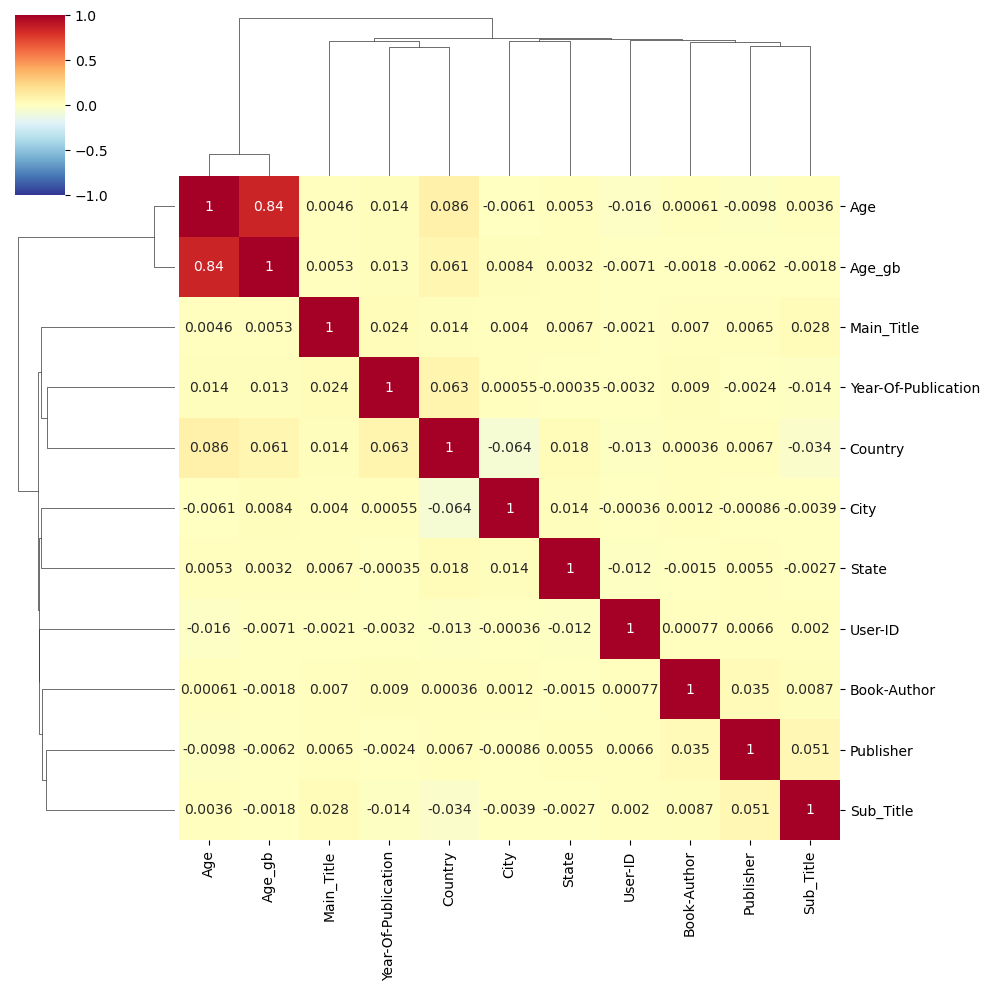

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), cmap = 'RdYlBu_r',vmin = -1, vmax = 1, annot = True)

In [12]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8400456	test: 3.8396211	best: 3.8396211 (0)	total: 82.6ms	remaining: 11m 58s
500:	learn: 3.3159642	test: 3.2881569	best: 3.2881569 (500)	total: 54.4s	remaining: 14m 49s
1000:	learn: 3.2725074	test: 3.2685493	best: 3.2685493 (1000)	total: 1m 43s	remaining: 13m 18s
1500:	learn: 3.2420614	test: 3.2609226	best: 3.2609205 (1498)	total: 2m 33s	remaining: 12m 17s
2000:	learn: 3.2155972	test: 3.2566057	best: 3.2566057 (2000)	total: 3m 24s	remaining: 11m 24s
2500:	learn: 3.1908457	test: 3.2533466	best: 3.2533445 (2496)	total: 4m 15s	remaining: 10m 32s
3000:	learn: 3.1675494	test: 3.2513126	best: 3.2513112 (2999)	total: 5m 6s	remaining: 9m 41s
3500:	learn: 3.1457237	test: 3.2496013	best: 3.2495838 (3492)	total: 5m 57s	remaining: 8m 50s
4000:	learn: 3.1238906	test: 3.2482931	best: 3.2482931 (4000)	total: 6m 49s	remaining: 7m 59s
4500:	learn: 3.1031344	test: 3.2474332	best: 3.2474212 (4481)	total: 7m 40s	remaining: 7m 8s
5000:	learn: 3.0825174	test: 3.2464534	best: 3.2464470 (

1it [09:18, 558.29s/it]


Fold  1
0:	learn: 3.8400140	test: 3.8396554	best: 3.8396554 (0)	total: 71.3ms	remaining: 10m 20s
500:	learn: 3.3166221	test: 3.2781521	best: 3.2781521 (500)	total: 48.2s	remaining: 13m 9s
1000:	learn: 3.2728528	test: 3.2578642	best: 3.2578642 (1000)	total: 1m 37s	remaining: 12m 31s
1500:	learn: 3.2417258	test: 3.2499270	best: 3.2499270 (1500)	total: 2m 27s	remaining: 11m 46s
2000:	learn: 3.2151828	test: 3.2451911	best: 3.2451911 (2000)	total: 3m 17s	remaining: 11m 1s
2500:	learn: 3.1910019	test: 3.2420335	best: 3.2420335 (2500)	total: 4m 8s	remaining: 10m 15s
3000:	learn: 3.1676781	test: 3.2398484	best: 3.2398484 (3000)	total: 4m 59s	remaining: 9m 28s
3500:	learn: 3.1454661	test: 3.2380732	best: 3.2380732 (3500)	total: 5m 50s	remaining: 8m 40s
4000:	learn: 3.1234192	test: 3.2367128	best: 3.2367043 (3998)	total: 6m 41s	remaining: 7m 51s
4500:	learn: 3.1027948	test: 3.2358988	best: 3.2358978 (4499)	total: 7m 32s	remaining: 7m 1s
5000:	learn: 3.0821304	test: 3.2350554	best: 3.2350554 (50

2it [20:10, 613.70s/it]


Fold  2
0:	learn: 3.8399945	test: 3.8394260	best: 3.8394260 (0)	total: 81.9ms	remaining: 11m 51s
500:	learn: 3.3180224	test: 3.2702678	best: 3.2702678 (500)	total: 48.6s	remaining: 13m 14s
1000:	learn: 3.2741325	test: 3.2490410	best: 3.2490410 (1000)	total: 1m 38s	remaining: 12m 34s
1500:	learn: 3.2421238	test: 3.2398063	best: 3.2398063 (1500)	total: 2m 27s	remaining: 11m 48s
2000:	learn: 3.2142607	test: 3.2349683	best: 3.2349656 (1997)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1895057	test: 3.2320349	best: 3.2320284 (2494)	total: 4m 9s	remaining: 10m 18s
3000:	learn: 3.1659406	test: 3.2299830	best: 3.2299830 (3000)	total: 5m	remaining: 9m 31s
3500:	learn: 3.1437985	test: 3.2282866	best: 3.2282831 (3491)	total: 5m 52s	remaining: 8m 42s
4000:	learn: 3.1223175	test: 3.2267622	best: 3.2267506 (3997)	total: 6m 43s	remaining: 7m 53s
4500:	learn: 3.1015605	test: 3.2259501	best: 3.2259501 (4500)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0820459	test: 3.2251864	best: 3.2251864 (5000)

3it [32:12, 663.15s/it]


Fold  3
0:	learn: 3.8400247	test: 3.8395264	best: 3.8395264 (0)	total: 84.9ms	remaining: 12m 18s
500:	learn: 3.3157070	test: 3.2749301	best: 3.2749301 (500)	total: 48.8s	remaining: 13m 18s
1000:	learn: 3.2726754	test: 3.2566788	best: 3.2566788 (1000)	total: 1m 38s	remaining: 12m 34s
1500:	learn: 3.2416723	test: 3.2494786	best: 3.2494786 (1500)	total: 2m 28s	remaining: 11m 49s
2000:	learn: 3.2147055	test: 3.2455896	best: 3.2455896 (2000)	total: 3m 18s	remaining: 11m 3s
2500:	learn: 3.1894994	test: 3.2429308	best: 3.2429217 (2498)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1660767	test: 3.2411169	best: 3.2411169 (3000)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1432800	test: 3.2398255	best: 3.2398255 (3500)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1212086	test: 3.2387194	best: 3.2387135 (3998)	total: 6m 42s	remaining: 7m 52s
4500:	learn: 3.1004539	test: 3.2379317	best: 3.2379239 (4453)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0797782	test: 3.2371429	best: 3.2371355 (4992)

4it [41:15, 615.56s/it]


Fold  4
0:	learn: 3.8400417	test: 3.8396061	best: 3.8396061 (0)	total: 71.6ms	remaining: 10m 22s
500:	learn: 3.3155276	test: 3.2845713	best: 3.2845713 (500)	total: 48.4s	remaining: 13m 11s
1000:	learn: 3.2719245	test: 3.2649703	best: 3.2649703 (1000)	total: 1m 37s	remaining: 12m 31s
1500:	learn: 3.2401266	test: 3.2572737	best: 3.2572727 (1499)	total: 2m 27s	remaining: 11m 46s
2000:	learn: 3.2126779	test: 3.2529413	best: 3.2529387 (1997)	total: 3m 18s	remaining: 11m 2s
2500:	learn: 3.1870442	test: 3.2500762	best: 3.2500762 (2498)	total: 4m 9s	remaining: 10m 16s
3000:	learn: 3.1636191	test: 3.2479124	best: 3.2479122 (2999)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1414578	test: 3.2468399	best: 3.2468380 (3497)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1195280	test: 3.2456647	best: 3.2456647 (4000)	total: 6m 42s	remaining: 7m 52s
4500:	learn: 3.0992815	test: 3.2450445	best: 3.2450445 (4500)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0789619	test: 3.2443125	best: 3.2443125 (4999)

5it [52:12, 630.41s/it]


Fold  5
0:	learn: 3.8400475	test: 3.8394178	best: 3.8394178 (0)	total: 101ms	remaining: 14m 39s
500:	learn: 3.3174659	test: 3.2718773	best: 3.2718773 (500)	total: 48.6s	remaining: 13m 14s
1000:	learn: 3.2737447	test: 3.2527031	best: 3.2527031 (1000)	total: 1m 38s	remaining: 12m 33s
1500:	learn: 3.2424732	test: 3.2450049	best: 3.2450049 (1500)	total: 2m 27s	remaining: 11m 47s
2000:	learn: 3.2162228	test: 3.2404968	best: 3.2404931 (1999)	total: 3m 18s	remaining: 11m 3s
2500:	learn: 3.1916223	test: 3.2372900	best: 3.2372806 (2499)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1683041	test: 3.2351647	best: 3.2351577 (2998)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1462295	test: 3.2334373	best: 3.2334349 (3498)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1248153	test: 3.2319107	best: 3.2319055 (3998)	total: 6m 42s	remaining: 7m 52s
4500:	learn: 3.1038027	test: 3.2308997	best: 3.2308997 (4500)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0828332	test: 3.2299200	best: 3.2299193 (4999)	

6it [1:02:57, 635.36s/it]


Fold  6
0:	learn: 3.8400941	test: 3.8395439	best: 3.8395439 (0)	total: 83.3ms	remaining: 12m 4s
500:	learn: 3.3163369	test: 3.2801457	best: 3.2801457 (500)	total: 48.7s	remaining: 13m 16s
1000:	learn: 3.2723384	test: 3.2605702	best: 3.2605702 (1000)	total: 1m 38s	remaining: 12m 34s
1500:	learn: 3.2404252	test: 3.2523961	best: 3.2523961 (1500)	total: 2m 27s	remaining: 11m 47s
2000:	learn: 3.2130759	test: 3.2477028	best: 3.2477006 (1998)	total: 3m 18s	remaining: 11m 3s
2500:	learn: 3.1885001	test: 3.2445894	best: 3.2445894 (2500)	total: 4m 9s	remaining: 10m 16s
3000:	learn: 3.1649035	test: 3.2422760	best: 3.2422757 (2999)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1431277	test: 3.2404031	best: 3.2403981 (3494)	total: 5m 51s	remaining: 8m 40s
4000:	learn: 3.1217724	test: 3.2390606	best: 3.2390478 (3999)	total: 6m 42s	remaining: 7m 51s
4500:	learn: 3.1007244	test: 3.2380888	best: 3.2380632 (4482)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0806406	test: 3.2372605	best: 3.2372570 (4997)	

7it [1:14:52, 661.57s/it]


Fold  7
0:	learn: 3.8400052	test: 3.8396347	best: 3.8396347 (0)	total: 89ms	remaining: 12m 53s
500:	learn: 3.3166922	test: 3.2873149	best: 3.2873149 (500)	total: 50s	remaining: 13m 37s
1000:	learn: 3.2733015	test: 3.2674912	best: 3.2674912 (1000)	total: 1m 39s	remaining: 12m 41s
1500:	learn: 3.2426413	test: 3.2586854	best: 3.2586854 (1500)	total: 2m 28s	remaining: 11m 52s
2000:	learn: 3.2151689	test: 3.2537102	best: 3.2537102 (2000)	total: 3m 19s	remaining: 11m 5s
2500:	learn: 3.1906708	test: 3.2502068	best: 3.2502068 (2500)	total: 4m 9s	remaining: 10m 18s
3000:	learn: 3.1671773	test: 3.2476134	best: 3.2476134 (3000)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1450569	test: 3.2462107	best: 3.2461744 (3489)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1238150	test: 3.2450168	best: 3.2449981 (3986)	total: 6m 47s	remaining: 7m 57s
4500:	learn: 3.1029027	test: 3.2437483	best: 3.2437481 (4493)	total: 7m 39s	remaining: 7m 8s
5000:	learn: 3.0821424	test: 3.2425817	best: 3.2425799 (4999)	tot

8it [1:26:52, 680.12s/it]


Fold  8
0:	learn: 3.8400887	test: 3.8395697	best: 3.8395697 (0)	total: 83.3ms	remaining: 12m 4s
500:	learn: 3.3183915	test: 3.2598245	best: 3.2598245 (500)	total: 48.9s	remaining: 13m 19s
1000:	learn: 3.2751654	test: 3.2393518	best: 3.2393518 (1000)	total: 1m 38s	remaining: 12m 36s
1500:	learn: 3.2439544	test: 3.2317760	best: 3.2317647 (1497)	total: 2m 28s	remaining: 11m 49s
2000:	learn: 3.2161845	test: 3.2271536	best: 3.2271503 (1999)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1918645	test: 3.2245482	best: 3.2245482 (2500)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1685953	test: 3.2227622	best: 3.2227622 (3000)	total: 5m	remaining: 9m 30s
3500:	learn: 3.1461429	test: 3.2211888	best: 3.2211838 (3496)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1248416	test: 3.2202211	best: 3.2202100 (3999)	total: 6m 42s	remaining: 7m 51s
4500:	learn: 3.1040151	test: 3.2193263	best: 3.2193263 (4500)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0842615	test: 3.2183585	best: 3.2183585 (5000)	

9it [1:37:05, 659.15s/it]


Fold  9
0:	learn: 3.8400043	test: 3.8395820	best: 3.8395820 (0)	total: 71.7ms	remaining: 10m 23s
500:	learn: 3.3159686	test: 3.2882029	best: 3.2882029 (500)	total: 48.9s	remaining: 13m 20s
1000:	learn: 3.2719301	test: 3.2687995	best: 3.2687995 (1000)	total: 1m 38s	remaining: 12m 37s
1500:	learn: 3.2411841	test: 3.2607863	best: 3.2607863 (1500)	total: 2m 28s	remaining: 11m 51s
2000:	learn: 3.2144785	test: 3.2562219	best: 3.2562219 (2000)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1898492	test: 3.2533505	best: 3.2533430 (2499)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1668239	test: 3.2511493	best: 3.2511493 (3000)	total: 5m	remaining: 9m 30s
3500:	learn: 3.1446577	test: 3.2495996	best: 3.2495935 (3498)	total: 5m 52s	remaining: 8m 42s
4000:	learn: 3.1224568	test: 3.2485187	best: 3.2485187 (4000)	total: 6m 43s	remaining: 7m 52s
4500:	learn: 3.1021401	test: 3.2478684	best: 3.2478684 (4499)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0812544	test: 3.2472971	best: 3.2472965 (4999)

10it [1:48:17, 663.25s/it]


Fold  10
0:	learn: 3.8399947	test: 3.8395633	best: 3.8395633 (0)	total: 81ms	remaining: 11m 44s
500:	learn: 3.3173191	test: 3.2769888	best: 3.2769888 (500)	total: 48.8s	remaining: 13m 17s
1000:	learn: 3.2732084	test: 3.2568197	best: 3.2568182 (999)	total: 1m 38s	remaining: 12m 34s
1500:	learn: 3.2421037	test: 3.2487922	best: 3.2487915 (1499)	total: 2m 27s	remaining: 11m 48s
2000:	learn: 3.2157159	test: 3.2442026	best: 3.2442009 (1997)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1909712	test: 3.2412850	best: 3.2412850 (2500)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1682465	test: 3.2392422	best: 3.2392422 (3000)	total: 5m	remaining: 9m 30s
3500:	learn: 3.1457711	test: 3.2377434	best: 3.2377408 (3497)	total: 5m 52s	remaining: 8m 42s
4000:	learn: 3.1244092	test: 3.2367239	best: 3.2367239 (4000)	total: 6m 43s	remaining: 7m 52s
4500:	learn: 3.1037468	test: 3.2357885	best: 3.2357878 (4499)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0833100	test: 3.2353976	best: 3.2353157 (4973)	t

11it [1:59:18, 662.50s/it]


Fold  11
0:	learn: 3.8400010	test: 3.8395874	best: 3.8395874 (0)	total: 83.9ms	remaining: 12m 9s
500:	learn: 3.3168236	test: 3.2891734	best: 3.2891734 (500)	total: 48.5s	remaining: 13m 13s
1000:	learn: 3.2736971	test: 3.2686394	best: 3.2686394 (1000)	total: 1m 37s	remaining: 12m 31s
1500:	learn: 3.2427757	test: 3.2608871	best: 3.2608871 (1500)	total: 2m 27s	remaining: 11m 45s
2000:	learn: 3.2158155	test: 3.2562275	best: 3.2562275 (2000)	total: 3m 17s	remaining: 11m 1s
2500:	learn: 3.1913729	test: 3.2533091	best: 3.2533091 (2500)	total: 4m 8s	remaining: 10m 15s
3000:	learn: 3.1684957	test: 3.2512553	best: 3.2512553 (3000)	total: 4m 59s	remaining: 9m 27s
3500:	learn: 3.1458393	test: 3.2499726	best: 3.2499726 (3500)	total: 5m 50s	remaining: 8m 40s
4000:	learn: 3.1243460	test: 3.2488631	best: 3.2488631 (4000)	total: 6m 41s	remaining: 7m 51s
4500:	learn: 3.1032661	test: 3.2479817	best: 3.2479817 (4499)	total: 7m 32s	remaining: 7m 1s
5000:	learn: 3.0826559	test: 3.2472453	best: 3.2472453 (5

12it [2:11:36, 685.46s/it]


Fold  12
0:	learn: 3.8400209	test: 3.8394892	best: 3.8394892 (0)	total: 82.7ms	remaining: 11m 58s
500:	learn: 3.3171201	test: 3.2738561	best: 3.2738561 (500)	total: 48.6s	remaining: 13m 14s
1000:	learn: 3.2746686	test: 3.2534295	best: 3.2534295 (1000)	total: 1m 37s	remaining: 12m 32s
1500:	learn: 3.2439914	test: 3.2448427	best: 3.2448427 (1500)	total: 2m 27s	remaining: 11m 49s
2000:	learn: 3.2176691	test: 3.2405154	best: 3.2405105 (1999)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1923620	test: 3.2374831	best: 3.2374831 (2500)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1685156	test: 3.2353082	best: 3.2353037 (2999)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1457635	test: 3.2337469	best: 3.2337420 (3499)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1245479	test: 3.2325155	best: 3.2324829 (3972)	total: 6m 42s	remaining: 7m 52s
4500:	learn: 3.1035880	test: 3.2315470	best: 3.2315470 (4500)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0828819	test: 3.2310193	best: 3.2310179 (4999

13it [2:21:44, 662.02s/it]


Fold  13
0:	learn: 3.8400551	test: 3.8396210	best: 3.8396210 (0)	total: 80.6ms	remaining: 11m 41s
500:	learn: 3.3164636	test: 3.2832436	best: 3.2832436 (500)	total: 48.5s	remaining: 13m 13s
1000:	learn: 3.2724527	test: 3.2650238	best: 3.2650238 (1000)	total: 1m 37s	remaining: 12m 30s
1500:	learn: 3.2404964	test: 3.2573880	best: 3.2573880 (1500)	total: 2m 27s	remaining: 11m 45s
2000:	learn: 3.2127139	test: 3.2533675	best: 3.2533675 (2000)	total: 3m 17s	remaining: 11m
2500:	learn: 3.1874905	test: 3.2507592	best: 3.2507592 (2500)	total: 4m 8s	remaining: 10m 14s
3000:	learn: 3.1636883	test: 3.2486959	best: 3.2486924 (2998)	total: 5m 1s	remaining: 9m 32s
3500:	learn: 3.1417887	test: 3.2471415	best: 3.2471415 (3500)	total: 6m 6s	remaining: 9m 3s
4000:	learn: 3.1201904	test: 3.2462770	best: 3.2462743 (3983)	total: 7m 3s	remaining: 8m 17s
4500:	learn: 3.0997755	test: 3.2453209	best: 3.2453209 (4500)	total: 8m 1s	remaining: 7m 28s
5000:	learn: 3.0795940	test: 3.2445100	best: 3.2445075 (4987)	t

14it [2:33:34, 676.41s/it]


Fold  14
0:	learn: 3.8400289	test: 3.8395334	best: 3.8395334 (0)	total: 88.3ms	remaining: 12m 47s
500:	learn: 3.3168444	test: 3.2725135	best: 3.2725135 (500)	total: 1m 28s	remaining: 24m 4s
1000:	learn: 3.2734225	test: 3.2521234	best: 3.2521234 (1000)	total: 3m	remaining: 23m 6s
1500:	learn: 3.2414638	test: 3.2435466	best: 3.2435466 (1500)	total: 4m 37s	remaining: 22m 10s
2000:	learn: 3.2147140	test: 3.2389368	best: 3.2389300 (1997)	total: 6m 10s	remaining: 20m 38s
2500:	learn: 3.1903399	test: 3.2359286	best: 3.2359264 (2499)	total: 7m 45s	remaining: 19m 13s
3000:	learn: 3.1672768	test: 3.2337145	best: 3.2337145 (3000)	total: 9m 21s	remaining: 17m 44s
3500:	learn: 3.1450134	test: 3.2320036	best: 3.2320036 (3500)	total: 11m 26s	remaining: 16m 58s
4000:	learn: 3.1235607	test: 3.2307481	best: 3.2307481 (4000)	total: 15m 12s	remaining: 17m 49s
4500:	learn: 3.1025653	test: 3.2296556	best: 3.2296556 (4500)	total: 16m 41s	remaining: 15m 33s
5000:	learn: 3.0814001	test: 3.2289821	best: 3.2289

15it [2:55:13, 864.05s/it]


Fold  15
0:	learn: 3.8400477	test: 3.8393763	best: 3.8393763 (0)	total: 88.9ms	remaining: 12m 52s
500:	learn: 3.3175427	test: 3.2670925	best: 3.2670925 (500)	total: 54.9s	remaining: 14m 57s
1000:	learn: 3.2744334	test: 3.2466365	best: 3.2466365 (1000)	total: 1m 50s	remaining: 14m 9s
1500:	learn: 3.2436137	test: 3.2387358	best: 3.2387358 (1500)	total: 2m 46s	remaining: 13m 16s
2000:	learn: 3.2168657	test: 3.2344178	best: 3.2344178 (2000)	total: 3m 44s	remaining: 12m 32s
2500:	learn: 3.1917148	test: 3.2310661	best: 3.2310661 (2500)	total: 4m 42s	remaining: 11m 39s
3000:	learn: 3.1677577	test: 3.2291283	best: 3.2291283 (3000)	total: 5m 40s	remaining: 10m 45s
3500:	learn: 3.1451101	test: 3.2274906	best: 3.2274878 (3497)	total: 6m 37s	remaining: 9m 49s
4000:	learn: 3.1242579	test: 3.2259875	best: 3.2259875 (4000)	total: 7m 35s	remaining: 8m 54s
4500:	learn: 3.1030989	test: 3.2247621	best: 3.2247621 (4500)	total: 8m 33s	remaining: 7m 58s
5000:	learn: 3.0823962	test: 3.2239532	best: 3.223942

16it [3:07:23, 823.62s/it]


Fold  16
0:	learn: 3.8399942	test: 3.8395284	best: 3.8395284 (0)	total: 89.4ms	remaining: 12m 57s
500:	learn: 3.3156762	test: 3.2852053	best: 3.2852053 (500)	total: 54.9s	remaining: 14m 57s
1000:	learn: 3.2726919	test: 3.2659600	best: 3.2659600 (1000)	total: 1m 50s	remaining: 14m 6s
1500:	learn: 3.2419480	test: 3.2577200	best: 3.2577200 (1500)	total: 2m 45s	remaining: 13m 15s
2000:	learn: 3.2151736	test: 3.2529400	best: 3.2529400 (2000)	total: 3m 42s	remaining: 12m 25s
2500:	learn: 3.1905313	test: 3.2493997	best: 3.2493997 (2500)	total: 4m 42s	remaining: 11m 38s
3000:	learn: 3.1673630	test: 3.2469701	best: 3.2469701 (3000)	total: 5m 40s	remaining: 10m 46s
3500:	learn: 3.1453799	test: 3.2447987	best: 3.2447987 (3500)	total: 6m 38s	remaining: 9m 51s
4000:	learn: 3.1241932	test: 3.2430281	best: 3.2430281 (4000)	total: 7m 36s	remaining: 8m 55s
4500:	learn: 3.1037825	test: 3.2417425	best: 3.2417303 (4490)	total: 8m 34s	remaining: 7m 58s
5000:	learn: 3.0837390	test: 3.2408473	best: 3.240828

17it [3:22:46, 853.63s/it]


Fold  17
0:	learn: 3.8400970	test: 3.8394953	best: 3.8394953 (0)	total: 136ms	remaining: 19m 43s
500:	learn: 3.3177976	test: 3.2649312	best: 3.2649312 (500)	total: 1m 3s	remaining: 17m 24s
1000:	learn: 3.2740294	test: 3.2434051	best: 3.2434051 (1000)	total: 2m 3s	remaining: 15m 47s
1500:	learn: 3.2430014	test: 3.2347830	best: 3.2347830 (1500)	total: 2m 59s	remaining: 14m 18s
2000:	learn: 3.2164804	test: 3.2299838	best: 3.2299838 (2000)	total: 3m 58s	remaining: 13m 16s
2500:	learn: 3.1921292	test: 3.2267274	best: 3.2267274 (2500)	total: 4m 59s	remaining: 12m 20s
3000:	learn: 3.1689130	test: 3.2243223	best: 3.2243156 (2995)	total: 5m 59s	remaining: 11m 21s
3500:	learn: 3.1466660	test: 3.2224768	best: 3.2224762 (3499)	total: 6m 56s	remaining: 10m 18s
4000:	learn: 3.1253207	test: 3.2211969	best: 3.2211937 (3999)	total: 7m 54s	remaining: 9m 16s
4500:	learn: 3.1048354	test: 3.2200136	best: 3.2200045 (4467)	total: 8m 52s	remaining: 8m 15s
5000:	learn: 3.0849682	test: 3.2192828	best: 3.219276

18it [3:33:14, 785.83s/it]


Fold  18
0:	learn: 3.8400100	test: 3.8395347	best: 3.8395347 (0)	total: 89.5ms	remaining: 12m 58s
500:	learn: 3.3164476	test: 3.2825574	best: 3.2825574 (500)	total: 54.3s	remaining: 14m 47s
1000:	learn: 3.2728988	test: 3.2636094	best: 3.2636094 (1000)	total: 1m 49s	remaining: 13m 59s
1500:	learn: 3.2407577	test: 3.2556163	best: 3.2556163 (1500)	total: 2m 44s	remaining: 13m 8s
2000:	learn: 3.2130127	test: 3.2513396	best: 3.2513396 (2000)	total: 3m 41s	remaining: 12m 20s
2500:	learn: 3.1878982	test: 3.2480090	best: 3.2480090 (2500)	total: 4m 38s	remaining: 11m 28s
3000:	learn: 3.1641947	test: 3.2459809	best: 3.2459669 (2991)	total: 5m 36s	remaining: 10m 39s
3500:	learn: 3.1418597	test: 3.2446915	best: 3.2446800 (3497)	total: 6m 39s	remaining: 9m 53s
4000:	learn: 3.1199029	test: 3.2437472	best: 3.2437394 (3989)	total: 7m 41s	remaining: 9m 1s
4500:	learn: 3.0987956	test: 3.2426752	best: 3.2426696 (4497)	total: 8m 44s	remaining: 8m 8s
5000:	learn: 3.0783503	test: 3.2419797	best: 3.2419710 

19it [3:45:59, 779.50s/it]


Fold  19
0:	learn: 3.8400554	test: 3.8396289	best: 3.8396289 (0)	total: 107ms	remaining: 15m 30s
500:	learn: 3.3159817	test: 3.2924027	best: 3.2924027 (500)	total: 57.1s	remaining: 15m 33s
1000:	learn: 3.2729189	test: 3.2730009	best: 3.2730009 (1000)	total: 1m 56s	remaining: 14m 55s
1500:	learn: 3.2415515	test: 3.2649030	best: 3.2649030 (1500)	total: 2m 56s	remaining: 14m 4s
2000:	learn: 3.2139139	test: 3.2601046	best: 3.2601046 (2000)	total: 3m 55s	remaining: 13m 6s
2500:	learn: 3.1890782	test: 3.2572053	best: 3.2571954 (2498)	total: 4m 54s	remaining: 12m 8s
3000:	learn: 3.1656220	test: 3.2549776	best: 3.2549776 (3000)	total: 5m 54s	remaining: 11m 12s
3500:	learn: 3.1432190	test: 3.2534954	best: 3.2534954 (3500)	total: 6m 55s	remaining: 10m 15s
4000:	learn: 3.1217791	test: 3.2524161	best: 3.2524046 (3993)	total: 7m 52s	remaining: 9m 14s
4500:	learn: 3.1009145	test: 3.2514696	best: 3.2514653 (4487)	total: 8m 50s	remaining: 8m 14s
5000:	learn: 3.0802472	test: 3.2506513	best: 3.2505999 

20it [3:57:21, 712.10s/it]


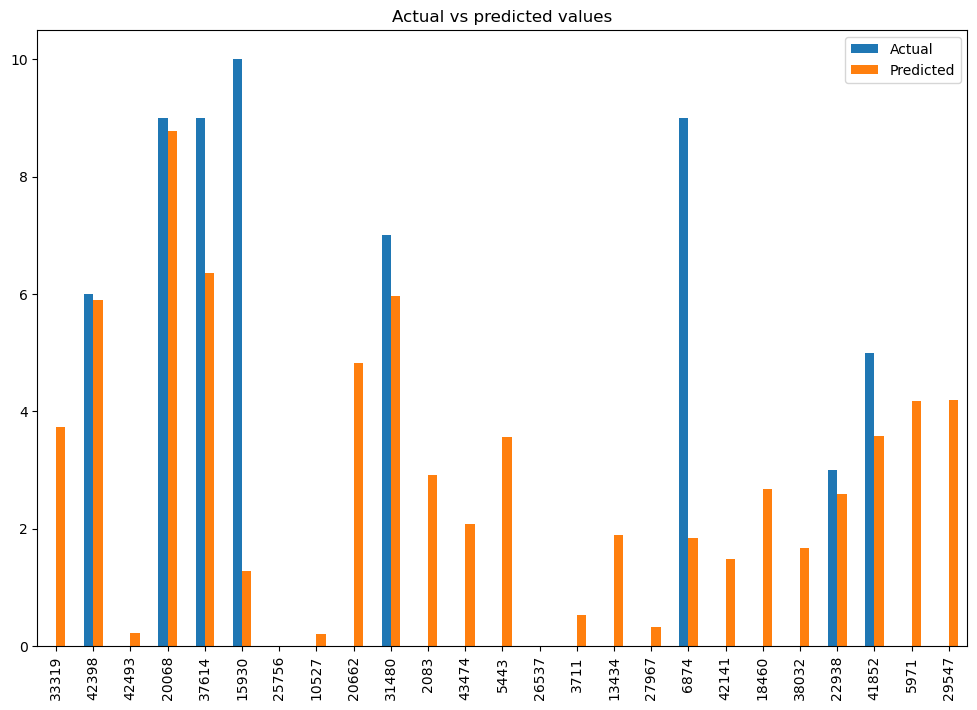

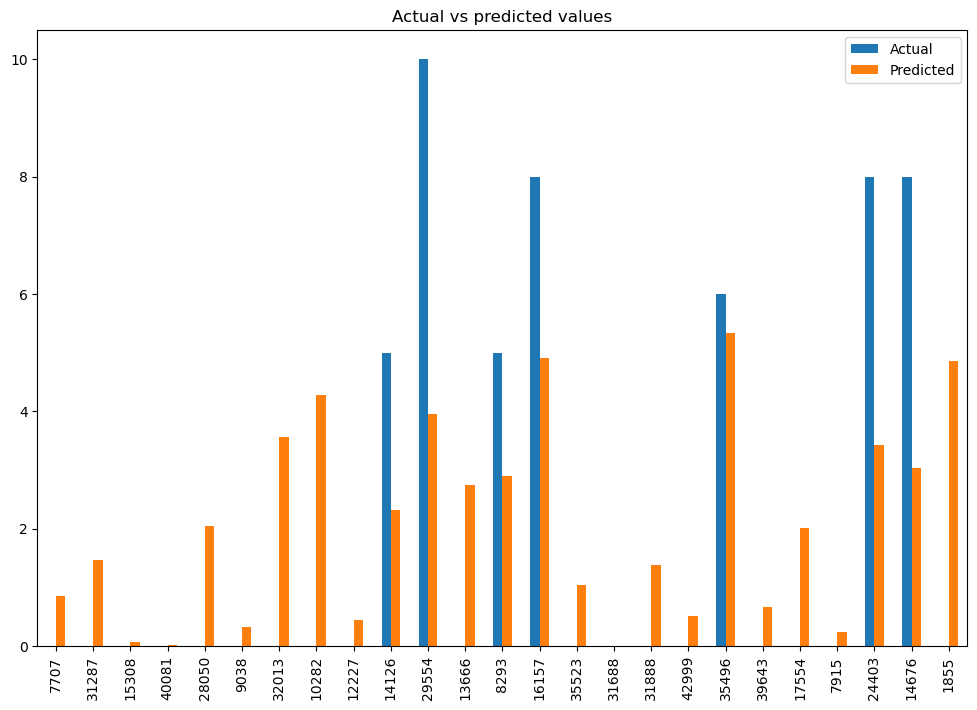

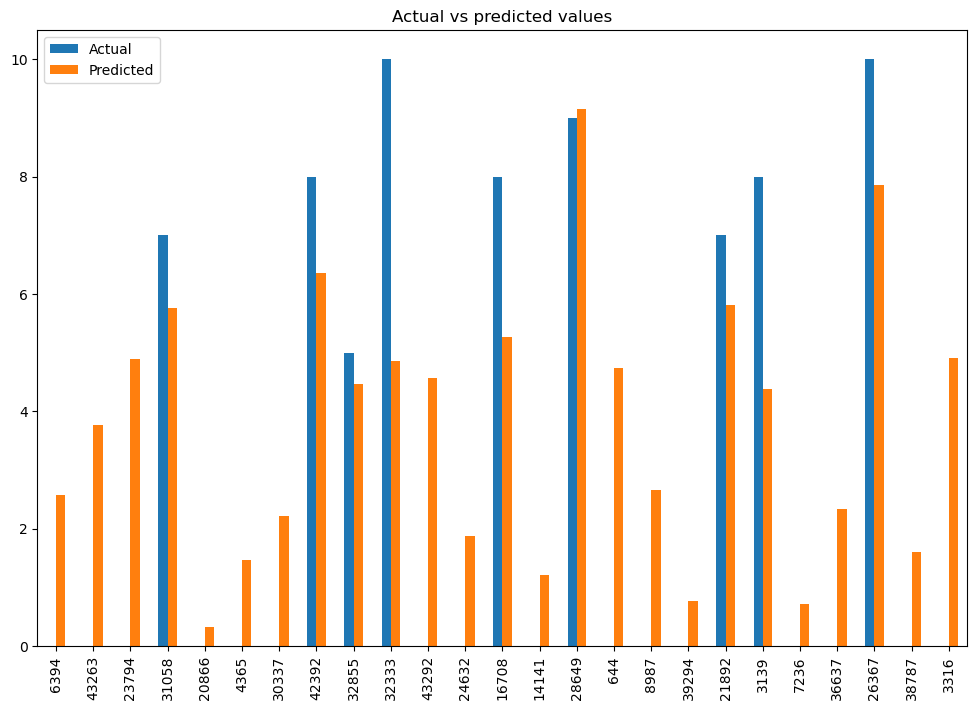

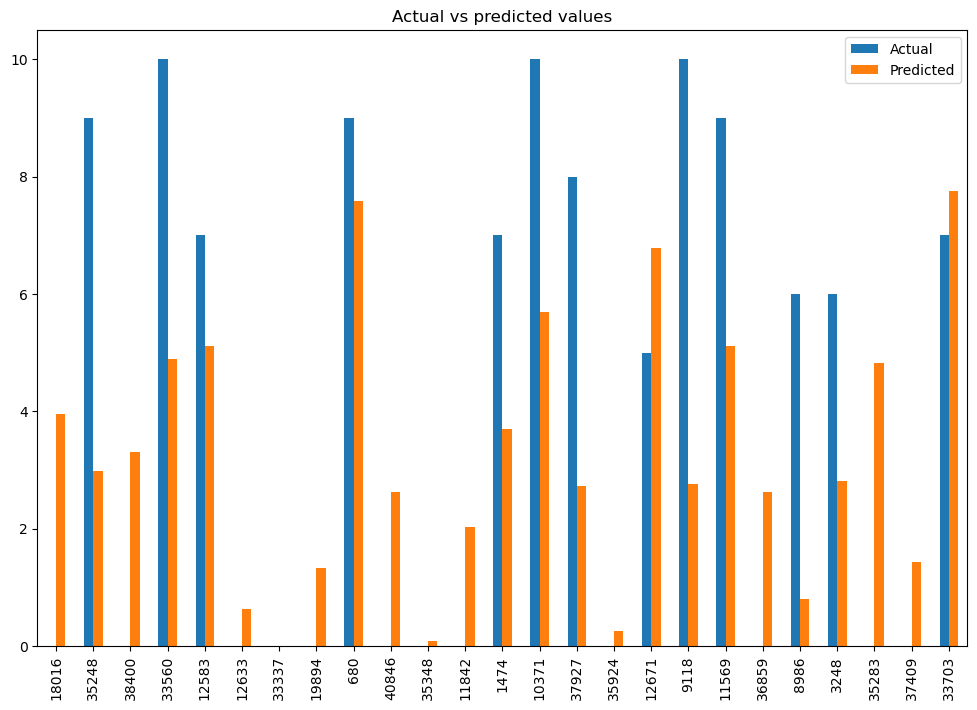

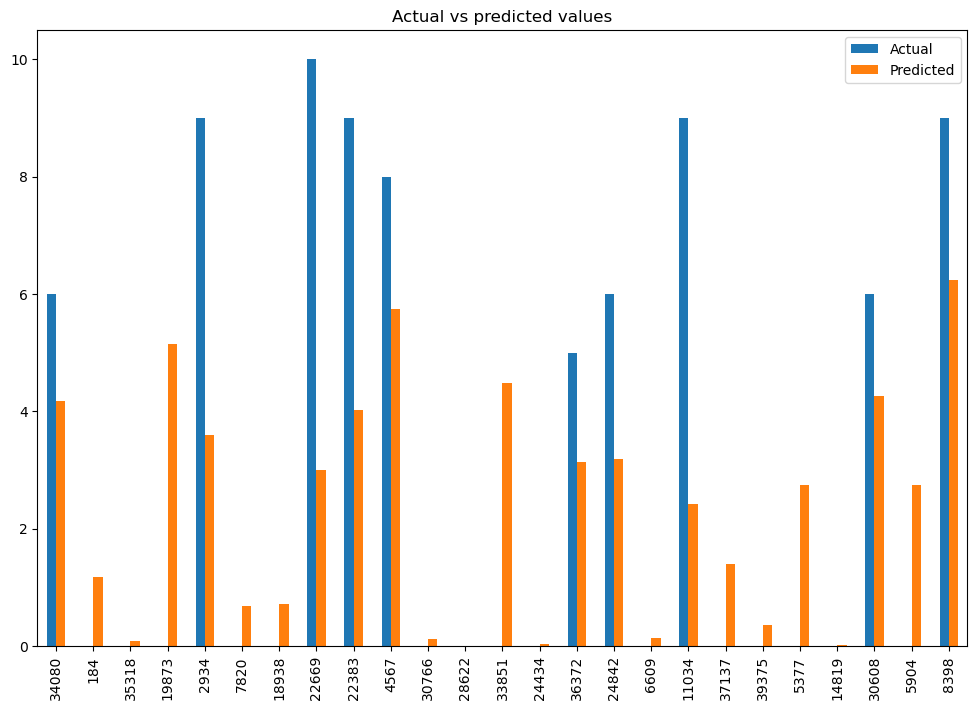

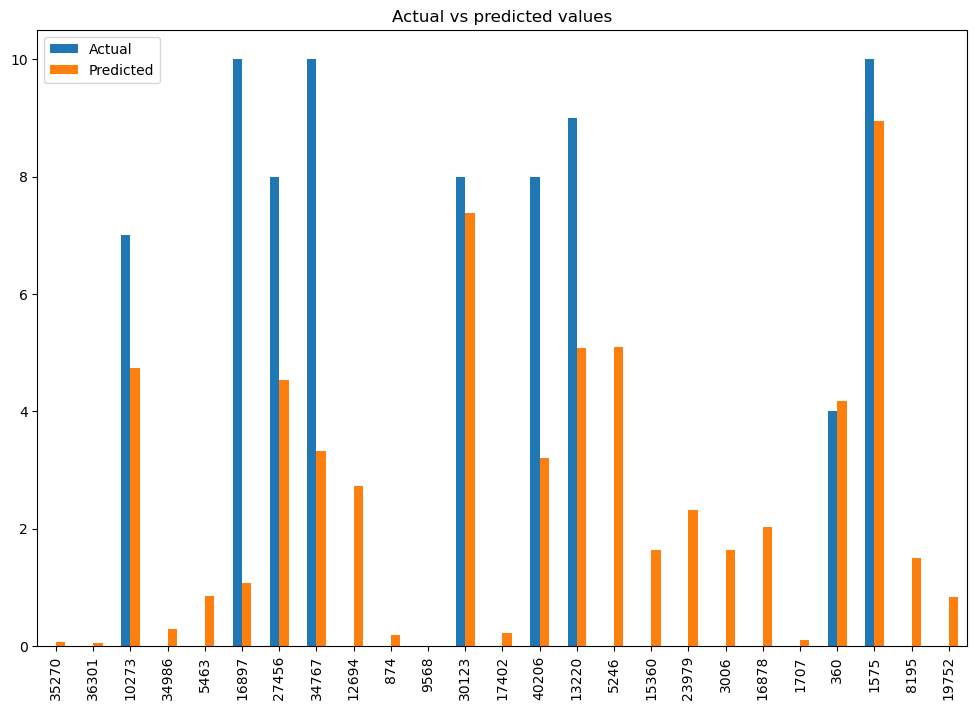

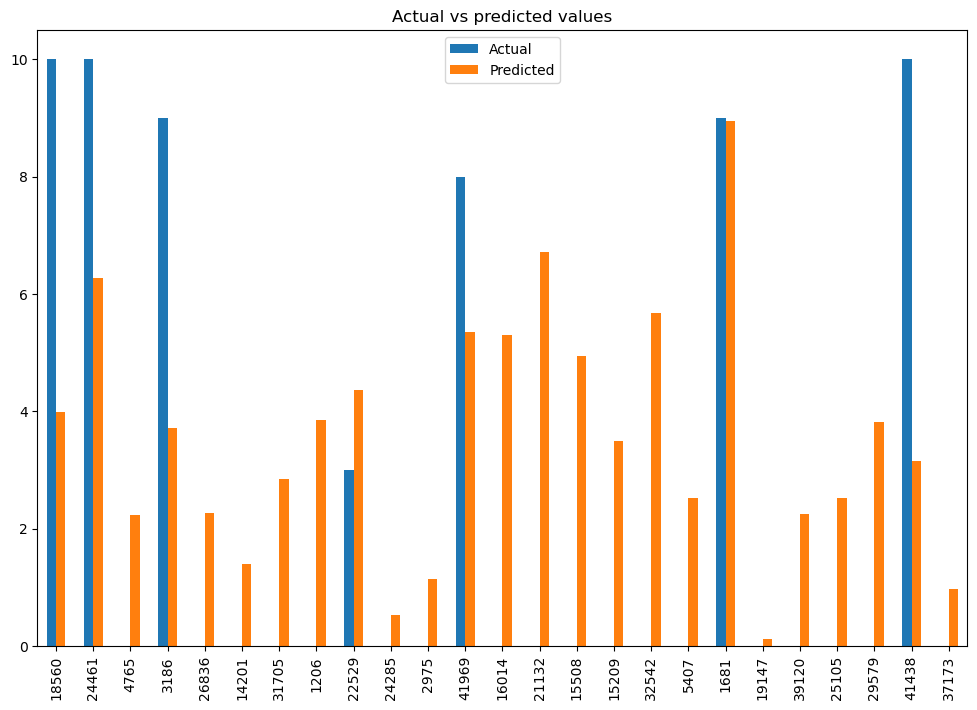

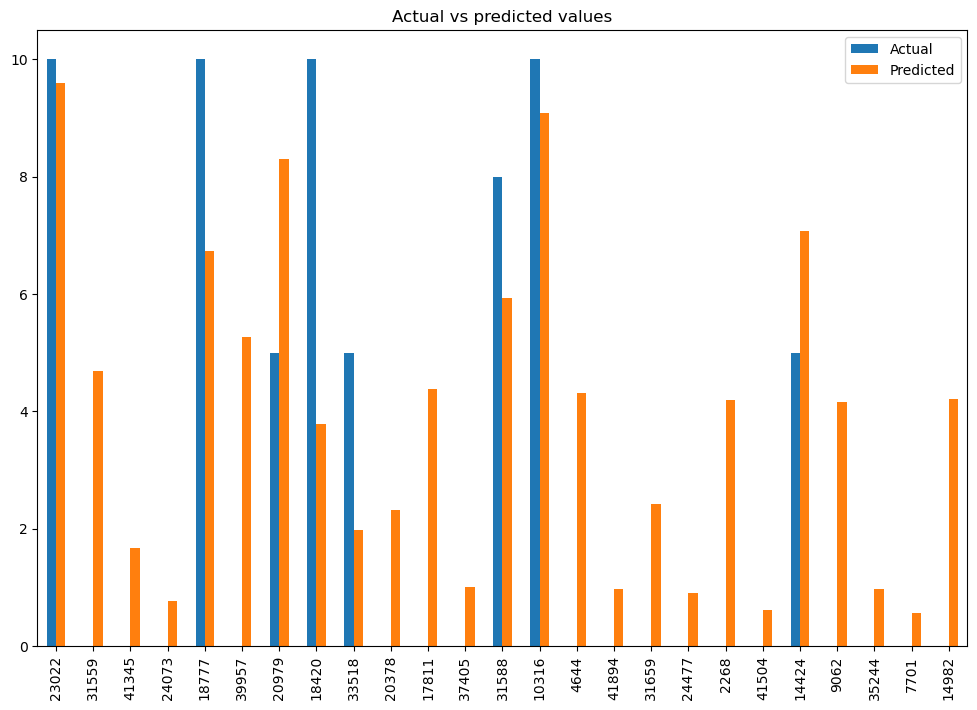

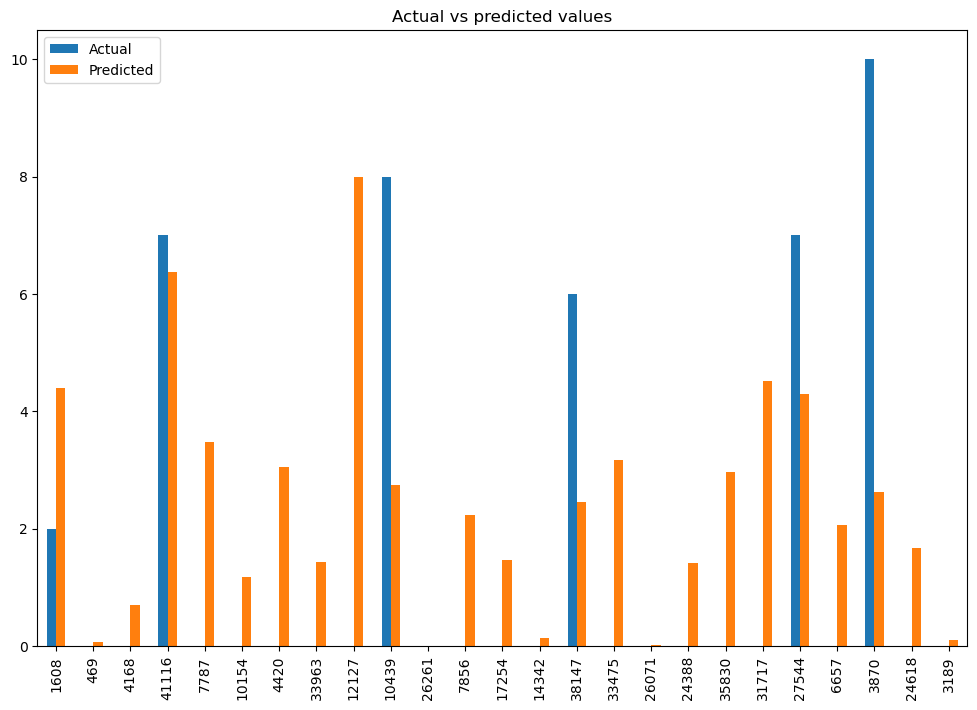

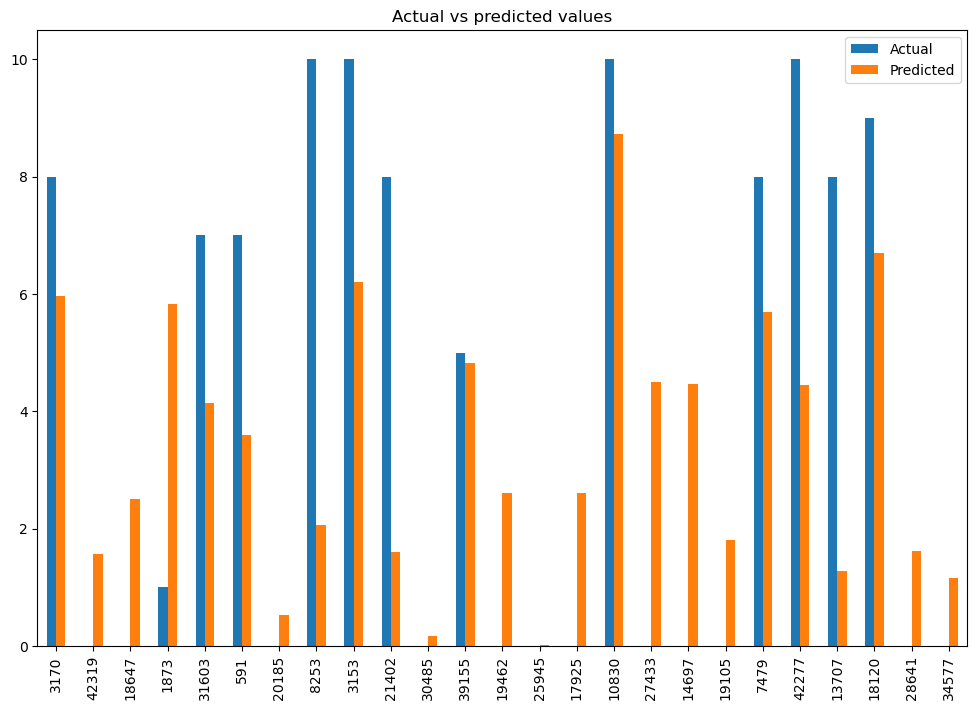

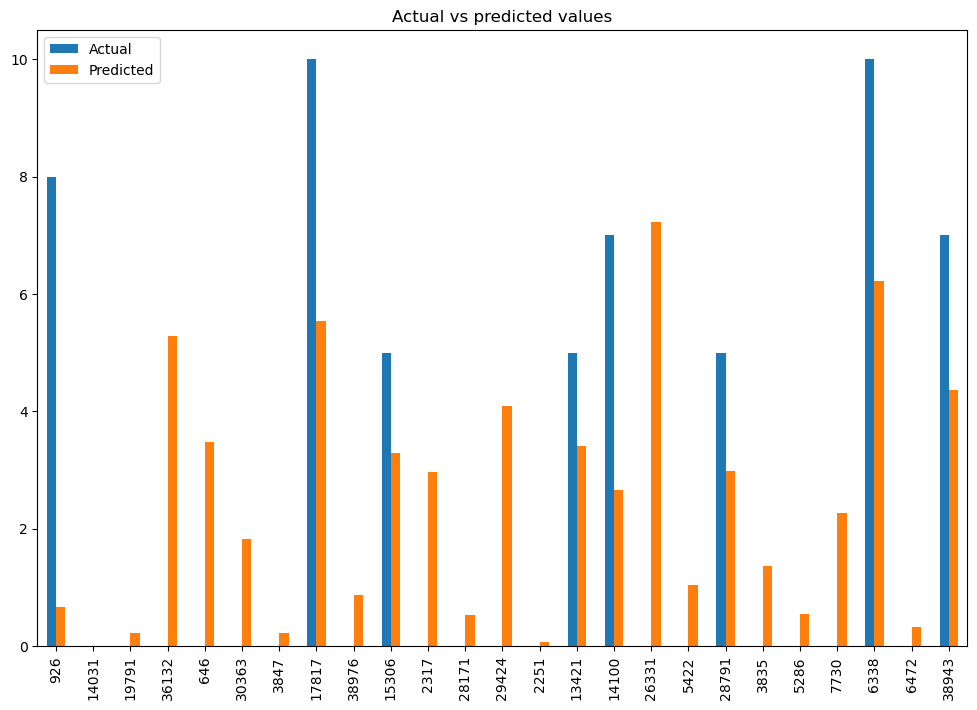

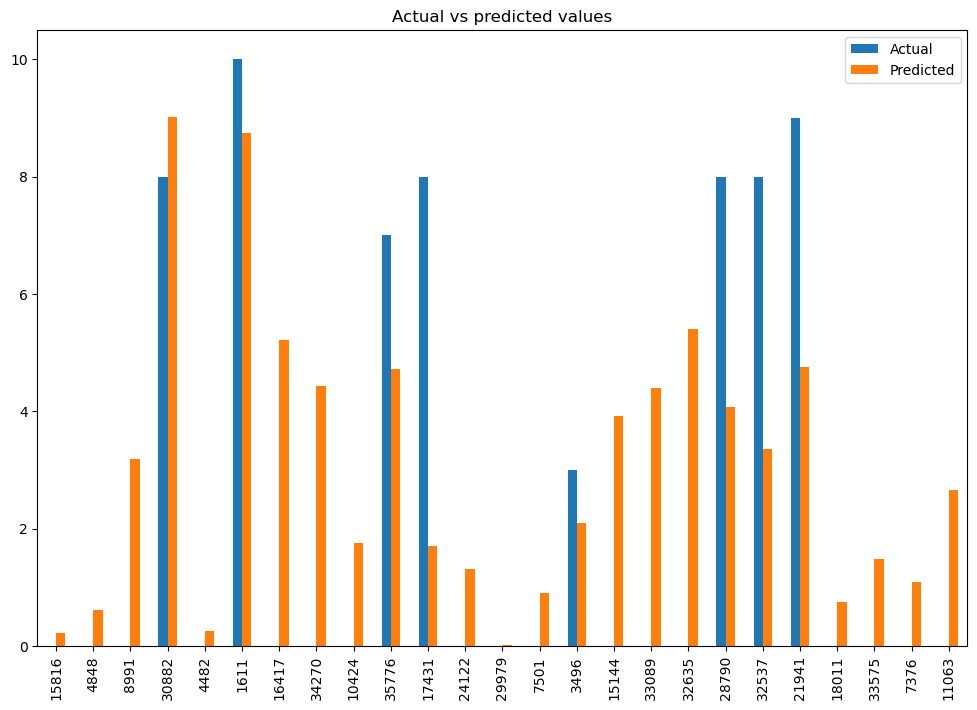

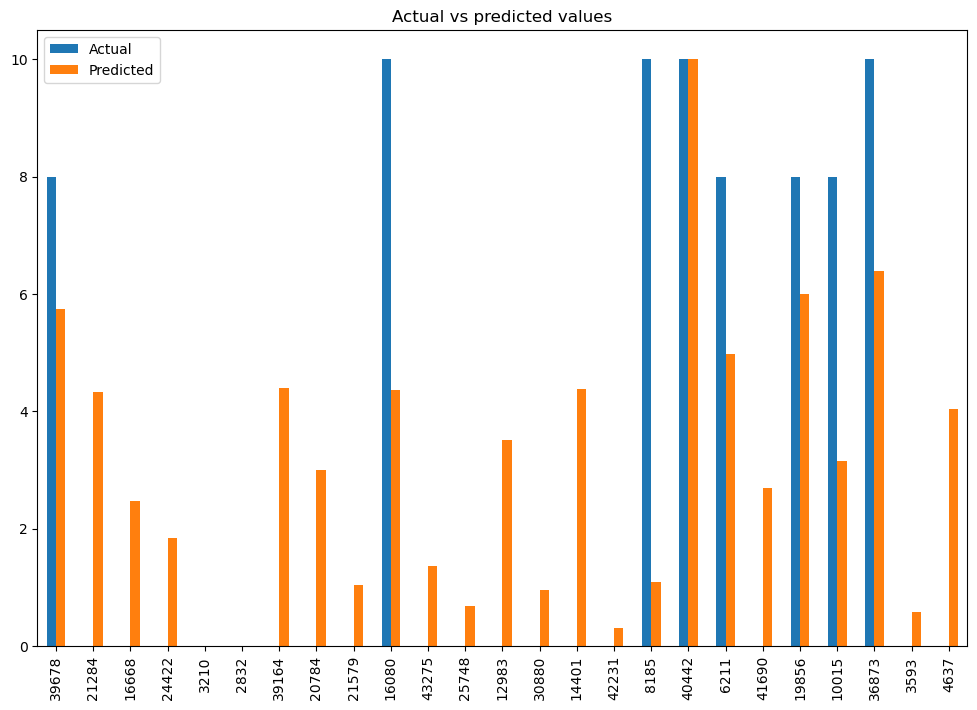

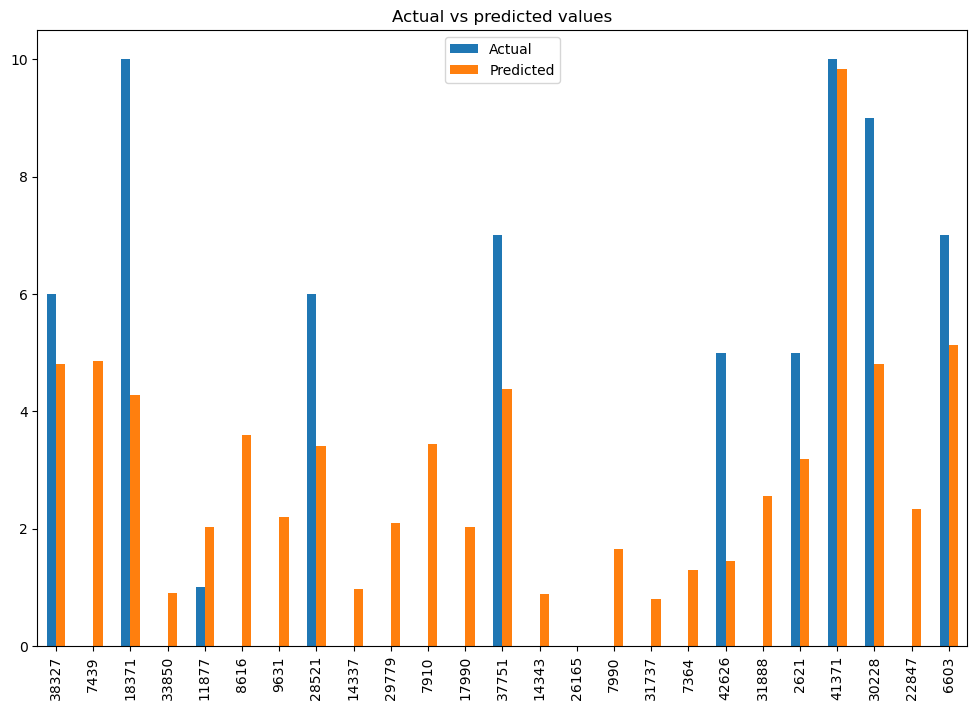

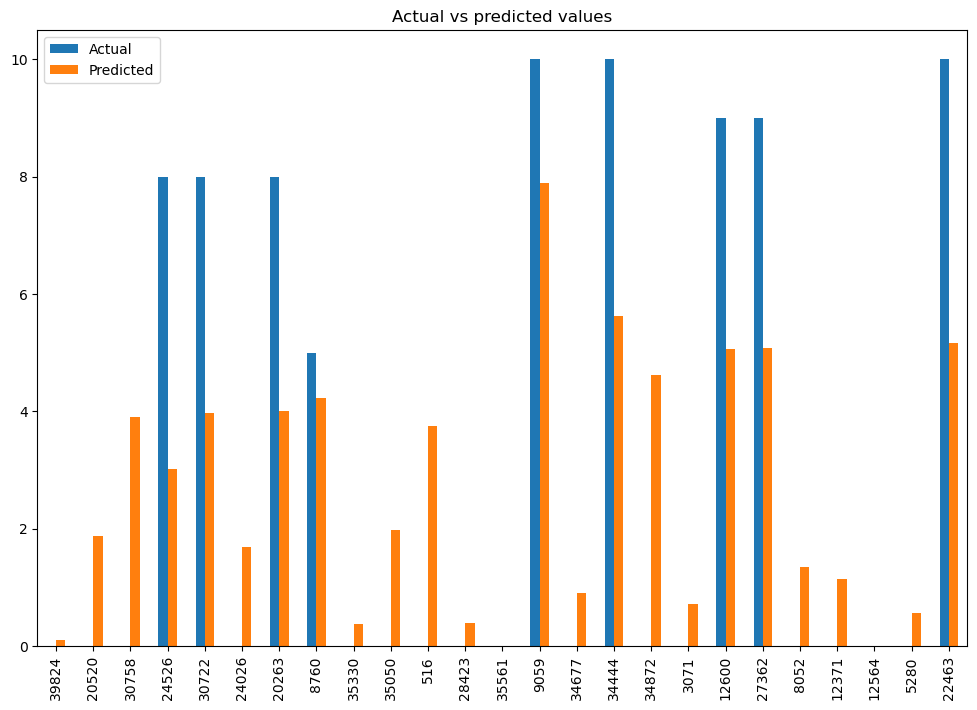

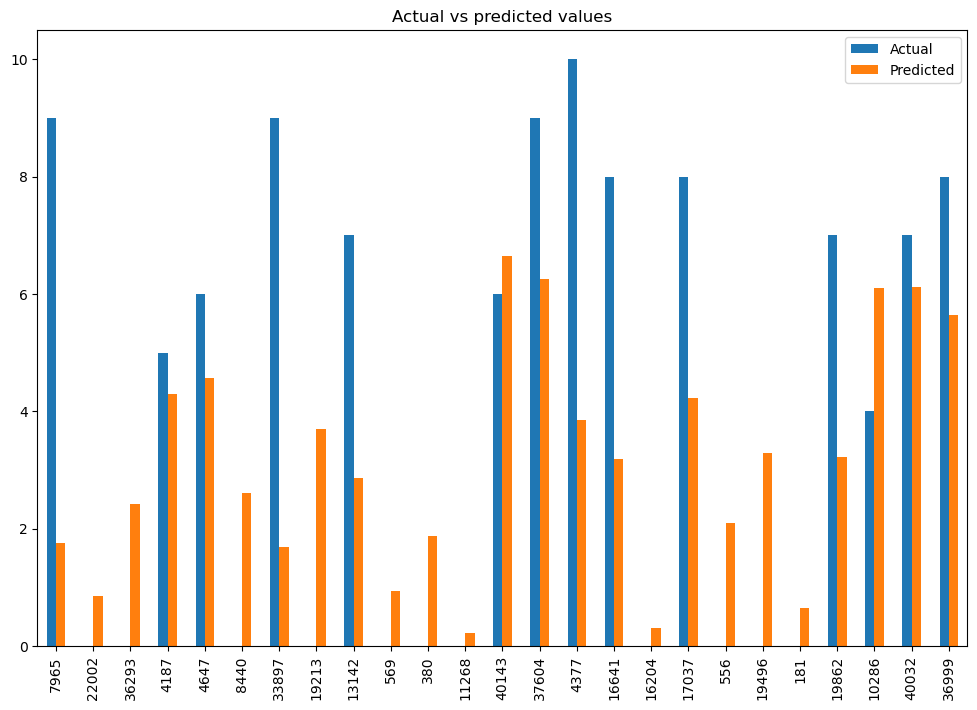

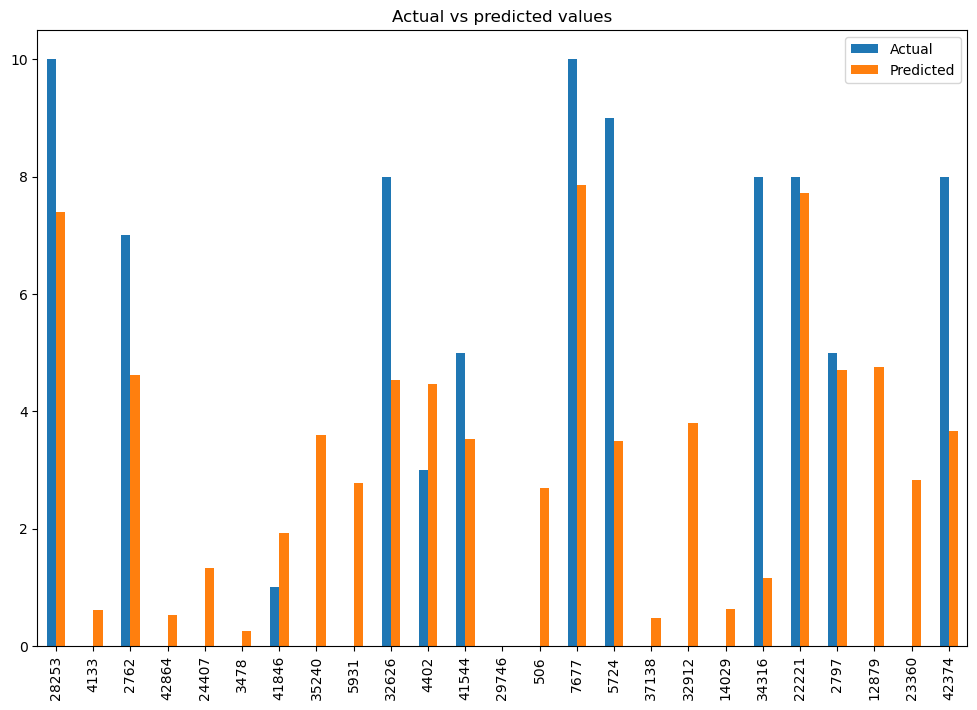

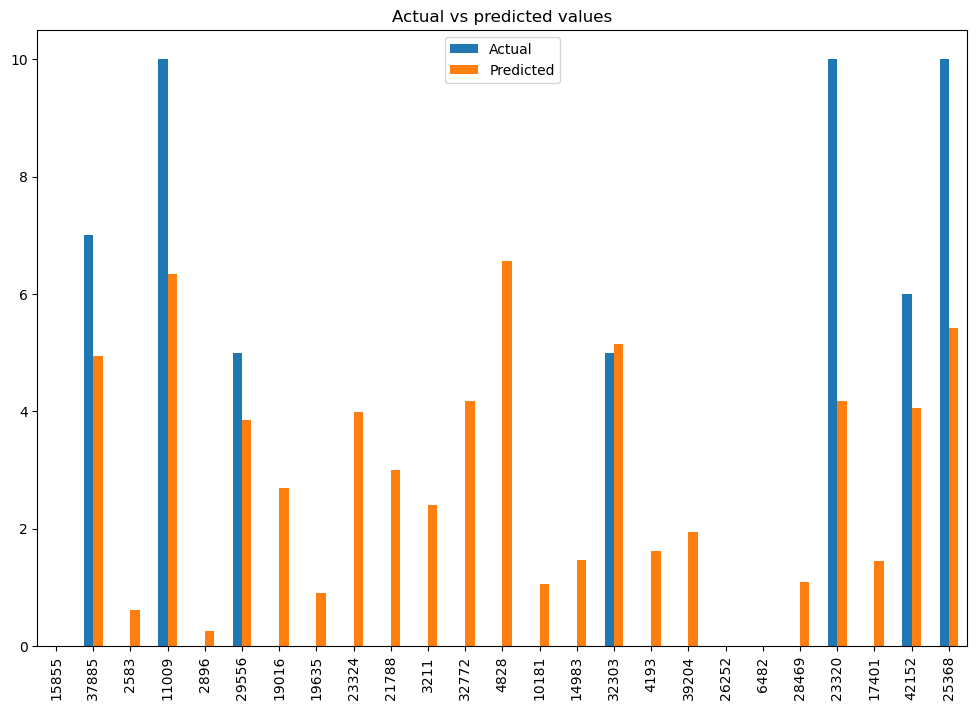

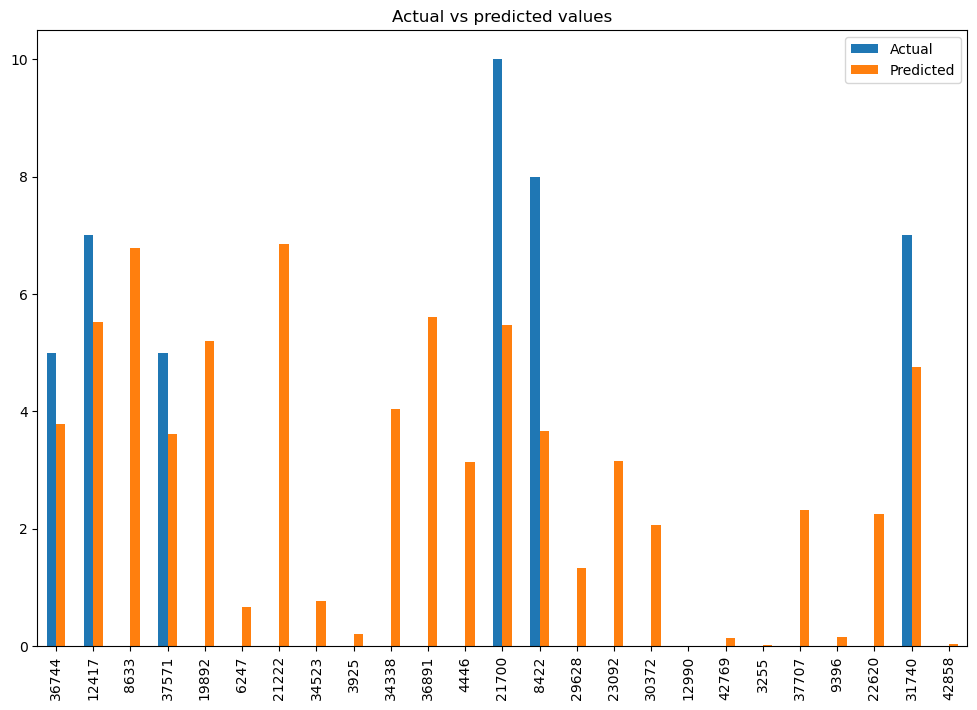

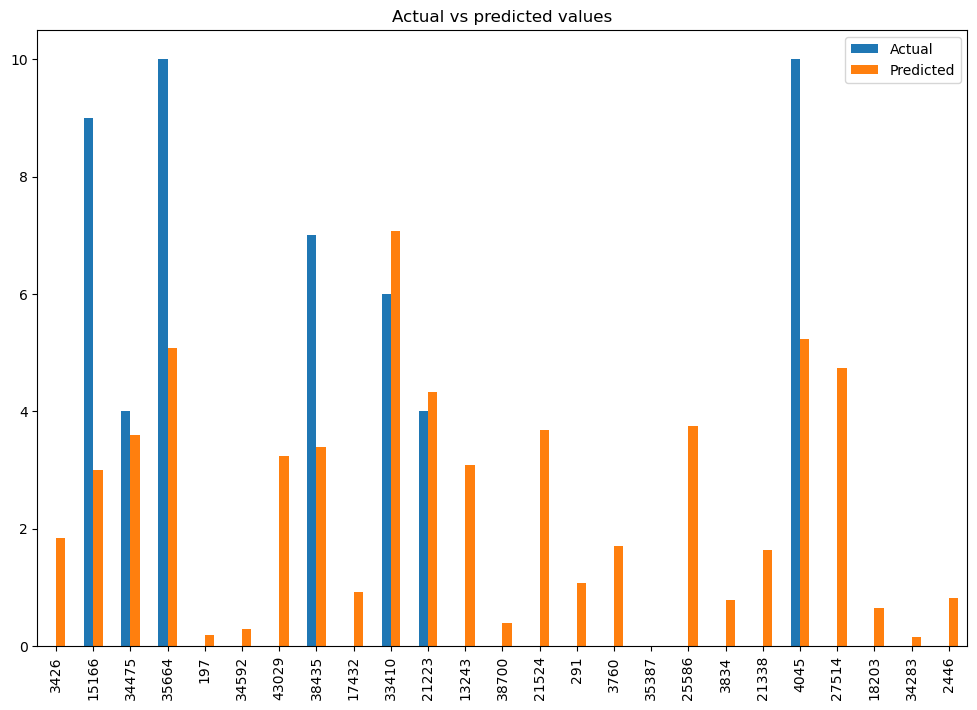

In [13]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


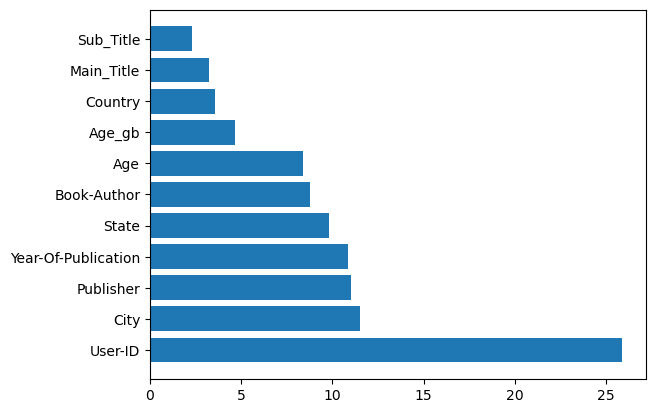

In [19]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [15]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.621887
1,TEST_000001,6.499768
2,TEST_000002,6.290895
3,TEST_000003,6.004890
4,TEST_000004,5.748082
...,...,...
159616,TEST_159616,3.992949
159617,TEST_159617,3.809629
159618,TEST_159618,3.644245
159619,TEST_159619,3.779080


<Axes: xlabel='Book-Rating', ylabel='Count'>

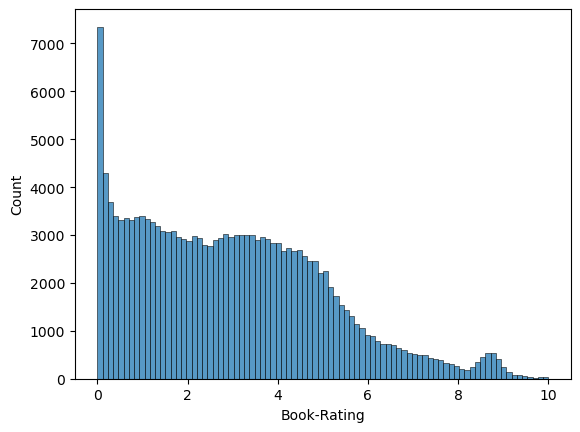

In [16]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [17]:
sub.to_csv('submit_cat+20-folds+split.+split2.csv', index=False,encoding="utf-8-sig")